In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("03_data/train_data.csv")
df_test = pd.read_csv("03_data/test_data.csv")

In [3]:
df_train.head()

,id,pixels,class
0,15002,"[-0.10046728971962617, -0.10046728971962617, -...",1
1,15003,"[-0.10046728971962617, -0.10046728971962617, -...",0
2,15006,"[-0.10046728971962617, -0.10046728971962617, -...",0
3,15010,"[-0.10046728971962617, -0.10046728971962617, -...",0
4,15011,"[-0.10046728971962617, -0.10046728971962617, -...",0


In [4]:
df_train.info()
df_train.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      856 non-null    int64 
 1   pixels  856 non-null    object
 2   class   856 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 20.2+ KB


,id,pixels,class
count,856.000000,856,856.000000
unique,NaN,848,NaN
top,NaN,"[-0.10046728971962617, -0.10046728971962617, -...",NaN
freq,NaN,9,NaN
mean,16025.853972,NaN,0.193925
std,572.093487,NaN,0.395602
min,15002.000000,NaN,0.000000
25%,15548.250000,NaN,0.000000
50%,16032.000000,NaN,0.000000
75%,16525.500000,NaN,0.000000


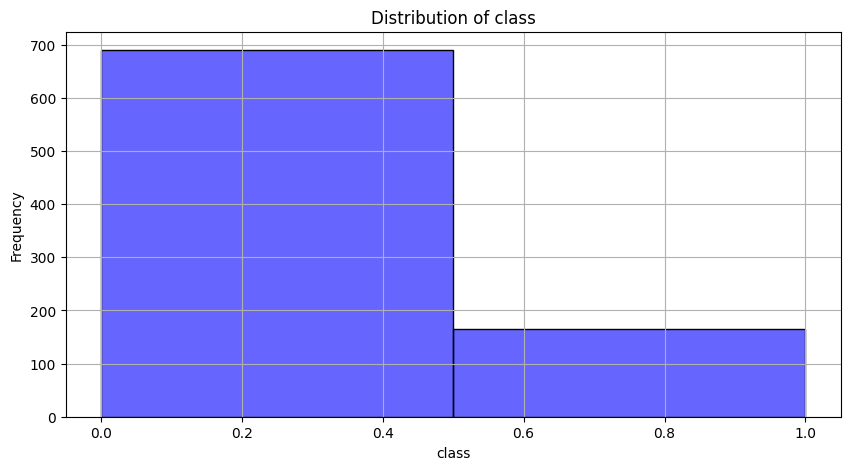

In [5]:
# Plot the distribution of target label
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(df, col):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], bins=2, color="blue", alpha=0.6)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


# Am vrut sa vad cum arata distributia label-ului
# in datele de train
plot_distribution(df_train, "class")

In [6]:
import ast

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

X_raw = np.vstack(df_train["pixels"].apply(ast.literal_eval).apply(np.array).values)
y = df_train["class"].values
train_ids = df_train["id"].values

In [7]:
mean_vec = X_raw.mean(axis=0)
X_centered = X_raw - mean_vec
std_vec = X_centered.std(axis=0)

X_z = X_centered / std_vec

X_train, X_val, y_train, y_val = train_test_split(
    X_z, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
rows_sub1 = []
for img_id, vec in zip(train_ids, X_centered):
    vec_str = "[" + ", ".join(f"{v:.5f}" for v in vec) + "]"
    rows_sub1.append((1, img_id, vec_str))

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipeline = Pipeline(
    [
        ("pca", PCA(n_components=500, random_state=42)),
        (
            "svm",
            SVC(
                kernel="rbf",
                class_weight="balanced",
                probability=True,
                C=5,
                gamma="scale",
                random_state=42,
            ),
        ),
    ]
)
pipeline.fit(X_train, y_train)
probs_svm = pipeline.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 17)
f1s = [f1_score(y_val, (probs_svm >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]

# Prob to threshold
y_val_pred = (probs_svm >= best_t).astype(int)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation F1 Score:", f1_score(y_val, y_val_pred))
print(
    "\nClassification Report:\n",
    classification_report(y_val, y_val_pred, target_names=["Normal", "Anomalous"]),
)


Validation Accuracy: 0.8430232558139535
Validation F1 Score: 0.5846153846153846

Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.91      0.90       139
   Anomalous       0.59      0.58      0.58        33

    accuracy                           0.84       172
   macro avg       0.75      0.74      0.74       172
weighted avg       0.84      0.84      0.84       172



In [10]:
X_test_raw = np.vstack(df_test["pixels"].apply(ast.literal_eval).apply(np.array).values)
test_ids = df_test["id"].values

X_test_centered = X_test_raw - mean_vec
X_test_z = X_test_centered / std_vec

probs_test = pipeline.predict(X_test_centered)
y_test_pred = (probs_svm >= best_t).astype(int)

In [11]:
rows_sub2 = [(2, img_id, int(lbl)) for img_id, lbl in zip(test_ids, y_test_pred)]

submission = pd.DataFrame(
    rows_sub1 + rows_sub2, columns=["subtaskID", "datapointID", "answer"]
)
submission.sort_values(["subtaskID", "datapointID"], inplace=True)
submission.to_csv("03_data/submission.csv", index=False)